In [44]:
# Summer 2021 Internship project with Oak Ride National Laboratory (ORNL)
# Code Written By: Arjun Viswanathan
# Mentored By: Dr. Junqi Yin
# Date Started: 6/7/2021
# Date TBC: 8/13/2021
# All datasets provided by Dr. Yin

import h5py
import numpy as np
from matplotlib import pyplot as plt
import time
from tensorflow import keras
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, UpSampling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Input, Model

In [2]:
print(str(time.ctime()) + ": Initializing...")
sarsmerscov_train = h5py.File('/ccs/proj/gen150/arjun2612/ORNL/datasets/sars-mers-cov2_train.h5', 'r')
sarsmerscov_val = h5py.File('/ccs/proj/gen150/arjun2612/ORNL/datasets/sars-mers-cov2_val.h5', 'r')
lt = list(open('/ccs/proj/gen150/arjun2612/ORNL/txtFiles/label_train.txt', 'r'))
lv = list(open('/ccs/proj/gen150/arjun2612/ORNL/txtFiles/label_val.txt', 'r')) # open all files

label_training = np.array([])
label_validation = np.array([])

train_size = 60000 # 10% of the datasets
val_size = 15000

for i in range(train_size):
    num = int(str(lt[i]).strip('\n'))
    label_training = np.append(label_training, num)
    
for j in range(val_size):
    num = int(str(lv[j]).strip('\n'))
    label_validation = np.append(label_validation, num)

trainset = np.array(sarsmerscov_train['contact_maps'][0:train_size]).astype(float) # 60000 x 24 x 24 x 1
valset = np.array(sarsmerscov_val['contact_maps'][0:val_size]).astype(float) # 15000 x 24 x 24 x 1

trainset, label_training = shuffle(trainset, label_training, random_state=0)
valset, label_validation = shuffle(valset, label_validation, random_state=0)

train_3D = np.tril(trainset[:, :, :, 0])
val_3D = np.tril(valset[:, :, :, 0])

lt_onehot = to_categorical(label_training) # make one hot vectors
lv_onehot = to_categorical(label_validation)

lt = None
lv = None
sarsmerscov_train = None
sarsmerscov_val = None # garbage collection to free up memory

print(str(time.ctime()) + ": Successfully loaded all data sets!")

Thu Jun 17 12:41:17 2021: Initializing...
Thu Jun 17 12:41:19 2021: Successfully loaded all data sets!


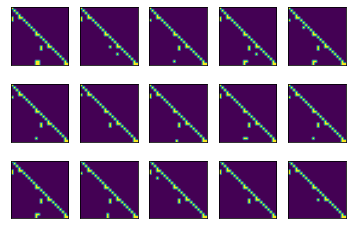

In [3]:
plt.figure(1)
for i in range(15):
    plt.subplot(3, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_3D[i, :, :])
plt.show()

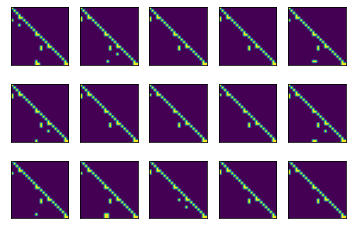

In [4]:
plt.figure(2)
for i in range(15):
    plt.subplot(3, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(val_3D[i, :, :])
plt.show()

In [45]:
print(str(time.ctime()) + ": Implementing PCA Clustering...")

train_pca = np.reshape(train_3D, (train_3D.shape[0], -1))  # 60000 x 576
val_pca = np.reshape(val_3D, (val_3D.shape[0], -1))  # 15000 x 576

normalized_train_pca = normalize(train_pca, axis=1, norm='l1')
normalized_val_pca = normalize(val_pca, axis=1, norm='l1')

pca = PCA(2)  # 2 PCs
pca.fit(normalized_train_pca)
reduced_train = pca.transform(normalized_train_pca)
reduced_val = pca.transform(normalized_val_pca) # reduce dimensions of both sets

print('Total explained variance: {}'.format(pca.explained_variance_ratio_.sum() * 100))

print(str(time.ctime()) + ": Finished PCA Clustering!")

Thu Jun 17 12:48:26 2021: Implementing PCA Clustering...
Total explained variance: 49.78138346235962
Thu Jun 17 12:48:27 2021: Finished PCA Clustering!


In [46]:
print(str(time.ctime()) + ": Implementing PCA ML...")

batch_size = 64
epochs = 20

pcamodel = Sequential()
pcamodel.add(Dense(128, activation='relu', input_shape=(2,)))
pcamodel.add(Dense(64, activation='relu'))
pcamodel.add(Dense(64, activation='relu'))
pcamodel.add(Dense(32, activation='relu'))
pcamodel.add(Dense(3, activation='softmax'))

early_stop = EarlyStopping(monitor='val_categorical_accuracy', patience=5, restore_best_weights=True)
pcamodel.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['categorical_accuracy'])
history = pcamodel.fit(reduced_train, lt_onehot, batch_size=batch_size, epochs=epochs, validation_data=(reduced_val, lv_onehot), callbacks=[early_stop])

print(str(time.ctime()) + ": Finished PCA ML")

Thu Jun 17 12:48:30 2021: Implementing PCA ML...
Epoch 1/20
938/938 [==============================] - 2s 1ms/step - loss: 0.6717 - categorical_accuracy: 0.6353 - val_loss: 0.5228 - val_categorical_accuracy: 0.6910
Epoch 2/20
938/938 [==============================] - 1s 1ms/step - loss: 0.5244 - categorical_accuracy: 0.6880 - val_loss: 0.5060 - val_categorical_accuracy: 0.7026
Epoch 3/20
938/938 [==============================] - 1s 1ms/step - loss: 0.5091 - categorical_accuracy: 0.6965 - val_loss: 0.5058 - val_categorical_accuracy: 0.6999
Epoch 4/20
938/938 [==============================] - 1s 1ms/step - loss: 0.4966 - categorical_accuracy: 0.7053 - val_loss: 0.4891 - val_categorical_accuracy: 0.7009
Epoch 5/20
938/938 [==============================] - 1s 1ms/step - loss: 0.4899 - categorical_accuracy: 0.7032 - val_loss: 0.4927 - val_categorical_accuracy: 0.7017
Epoch 6/20
938/938 [==============================] - 1s 1ms/step - loss: 0.4893 - categorical_accuracy: 0.7050 - val_los

In [47]:
print(str(time.ctime()) + ": Predicting with PCA Model...")

result = pcamodel.predict(reduced_val)
result = np.argmax(np.round(result), axis=1)

print(str(time.ctime()) + ": Finished predictions!")

Thu Jun 17 12:48:54 2021: Predicting with PCA Model...
Thu Jun 17 12:48:55 2021: Finished predictions!


In [48]:
correct = np.where(result == label_validation)[0]
incorrect = np.where(result != label_validation)[0]
print("Number of Correct Classifications: {}".format(len(correct)))
print("Number of Incorrect Classifications: {}".format(len(incorrect)))
print("Total Accuracy: {}".format((len(correct) / len(label_validation)) * 100))

Number of Correct Classifications: 10690
Number of Incorrect Classifications: 4310
Total Accuracy: 71.26666666666667


In [34]:
print(str(time.ctime()) + ": Implementing K-Means Clustering...")
km = KMeans(n_clusters=3, random_state=0)
km.fit(train_pca)
labels_val = np.array(km.predict(val_pca))

accuracy = (sum(labels_val == label_validation) / len(label_validation)) * 100

print('Accuracy: {}'.format(accuracy))
print(str(time.ctime()) + ": Finished K-Means Clustering!")

Thu Jun 17 12:45:56 2021: Implementing K-Means Clustering...
Accuracy: 66.12666666666667
Thu Jun 17 12:46:00 2021: Finished K-Means Clustering!


In [35]:
train_X, valid_X, train_label, valid_label = train_test_split(trainset, lt_onehot, test_size=0.2, random_state=0)
# train_X = samples x 24 x 24 x 1
# valid_X = samples x 24 x 24 x 1
# train_label = samples x 3
# valid_label = samples x 3

In [38]:
print(str(time.ctime()) + ": Creating Classification Model...")

x = Input(shape=(24, 24, 1))  # 24 x 24 x 1

# Encoder
e_conv1 = Conv2D(8, (3, 3), activation='relu', padding='same')(x) # 24 x 24 x 8
pool1 = MaxPool2D((2, 2), padding='same')(e_conv1) # 12 x 12 x 8
b_norm1 = BatchNormalization()(pool1)

e_conv2 = Conv2D(16, (3, 3), activation='relu', padding='same')(b_norm1) # 12 x 12 x 16
pool2 = MaxPool2D((2, 2), padding='same')(e_conv2) # 6 x 6 x 16
b_norm2 = BatchNormalization()(pool2)

e_conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(b_norm2) # 6 x 6 x 32
pool3 = MaxPool2D((2, 2), padding='same')(e_conv3) # 3 x 3 x 32
b_norm3 = BatchNormalization()(pool3)

e_conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(b_norm3) # 3 x 3 x 64
b_norm4 = BatchNormalization()(e_conv4)

e_conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(b_norm4) # 3 x 3 x 128
b_norm5 = BatchNormalization()(e_conv5)

# Decoder
d_conv1 = Conv2D(128, (3, 3), activation='relu', padding='same')(b_norm5) # 3 x 3 x 128
up1 = UpSampling2D((2, 2))(d_conv1) # 6 x 6 x 128
b_norm6 = BatchNormalization()(up1)

d_conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(b_norm6) # 6 x 6 x 64
up2 = UpSampling2D((2, 2))(d_conv2) # 12 x 12 x 64
b_norm7 = BatchNormalization()(up2)

d_conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(b_norm7) # 12 x 12 x 32
up3 = UpSampling2D((2, 2))(d_conv3) # 24 x 24 x 32
b_norm8 = BatchNormalization()(up3)

d_conv4 = Conv2D(16, (3, 3), activation='relu', padding='same')(b_norm8) # 24 x 24 x 16
b_norm9 = BatchNormalization()(d_conv4)

d_conv5 = Conv2D(8, (3, 3), activation='relu', padding='same')(b_norm9) # 24 x 24 x 8
b_norm10 = BatchNormalization()(d_conv5)

d_conv6 = Conv2D(1, (1, 1), activation='relu', padding='same')(b_norm10) # 24 x 24 x 1
b_norm11 = BatchNormalization()(d_conv6)

f1 = Flatten()(b_norm11) # add a fully connected layer after just the autoencoder. 576 x 1
r = Dense(3, activation='softmax')(f1) # 3 x 1

classification_model = Model(x, r) # compile full model
classification_model.compile(loss=keras.losses.categorical_crossentropy, optimizer='Adam', metrics=['categorical_accuracy'])

print(str(time.ctime()) + ": Successfully created Classification Model")

Thu Jun 17 12:46:29 2021: Creating Classification Model...
Thu Jun 17 12:46:29 2021: Successfully created Classification Model


In [39]:
print(str(time.ctime()) + ": Training Classification Model...")

epochs = 20
batch_size = 64
early_stop = EarlyStopping(monitor='val_categorical_accuracy', patience=5, restore_best_weights=True)
classify_labels = classification_model.fit(train_X, train_label, batch_size=batch_size, epochs=epochs, callbacks=[early_stop], validation_data=(valid_X, valid_label))

print(str(time.ctime()) + ": Finished training!")

Thu Jun 17 12:46:30 2021: Training Classification Model...
Epoch 1/20
750/750 [==============================] - 5s 5ms/step - loss: 0.4844 - categorical_accuracy: 0.7181 - val_loss: 0.4269 - val_categorical_accuracy: 0.7395
Epoch 2/20
750/750 [==============================] - 4s 5ms/step - loss: 0.4289 - categorical_accuracy: 0.7376 - val_loss: 0.4311 - val_categorical_accuracy: 0.7315
Epoch 3/20
750/750 [==============================] - 4s 5ms/step - loss: 0.4335 - categorical_accuracy: 0.7270 - val_loss: 0.4230 - val_categorical_accuracy: 0.7498
Epoch 4/20
750/750 [==============================] - 4s 5ms/step - loss: 0.4264 - categorical_accuracy: 0.7407 - val_loss: 0.4224 - val_categorical_accuracy: 0.7526
Epoch 5/20
750/750 [==============================] - 4s 5ms/step - loss: 0.4296 - categorical_accuracy: 0.7390 - val_loss: 0.4437 - val_categorical_accuracy: 0.7172
Epoch 6/20
750/750 [==============================] - 4s 5ms/step - loss: 0.4303 - categorical_accuracy: 0.7337

In [40]:
print(str(time.ctime()) + ": Evaluating Classification Model...")

test_eval = classification_model.evaluate(valid_X, valid_label)
print('Loss: {}'.format(test_eval[0]))
print('Accuracy: {}'.format(test_eval[1] * 100))

print(str(time.ctime()) + ": Finished evaluation!")

Thu Jun 17 12:47:05 2021: Evaluating Classification Model...
375/375 [==============================] - 1s 2ms/step - loss: 0.4224 - categorical_accuracy: 0.7526
Loss: 0.4223676323890686
Accuracy: 75.25833249092102
Thu Jun 17 12:47:06 2021: Finished evaluation!


In [41]:
print(str(time.ctime()) + ": Predicting with Classification Model...")

predicted = classification_model.predict(valset)
predicted = np.argmax(np.round(predicted), axis=1)

print(str(time.ctime()) + ": Finished predictions!")

Thu Jun 17 12:47:06 2021: Predicting with Classification Model...
Thu Jun 17 12:47:07 2021: Finished predictions!


In [42]:
correct = np.where(predicted == label_validation)[0]
incorrect = np.where(predicted != label_validation)[0]
print("Number of Correct Classifications: " + str(len(correct)))
print("Number of Incorrect Classifications: " + str(len(incorrect)))

Number of Correct Classifications: 11078
Number of Incorrect Classifications: 3922


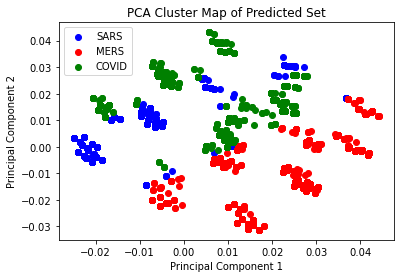

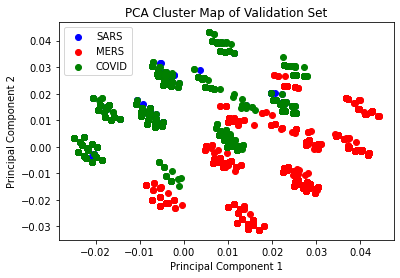

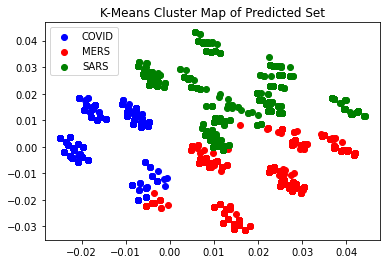

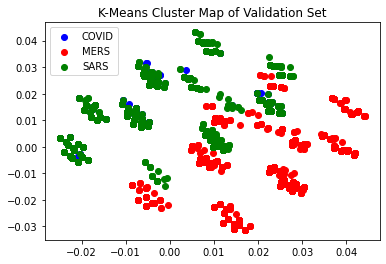

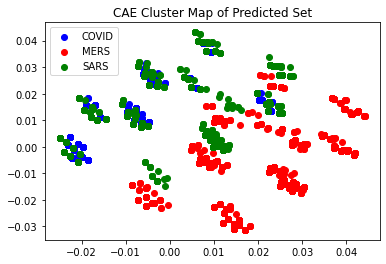

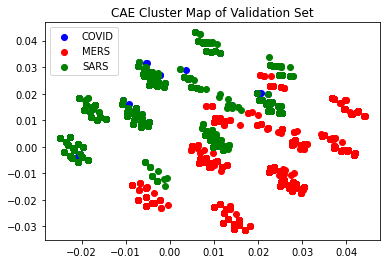

In [43]:
plt.figure(3)
plt.scatter(reduced_val[result == 0, 0], reduced_val[result == 0, 1], c='b', label='SARS', alpha=1)
plt.scatter(reduced_val[result == 1, 0], reduced_val[result == 1, 1], c='r', label='MERS', alpha=1)
plt.scatter(reduced_val[result == 2, 0], reduced_val[result == 2, 1], c='g', label='COVID', alpha=1)
plt.legend(loc='upper left')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Cluster Map of Predicted Set')

plt.figure(4)
plt.scatter(reduced_val[label_validation == 0, 0], reduced_val[label_validation == 0, 1], c='b', label='SARS', alpha=1)
plt.scatter(reduced_val[label_validation == 1, 0], reduced_val[label_validation == 1, 1], c='r', label='MERS', alpha=1)
plt.scatter(reduced_val[label_validation == 2, 0], reduced_val[label_validation == 2, 1], c='g', label='COVID', alpha=1)
plt.legend(loc='upper left')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Cluster Map of Validation Set')

plt.figure(5)
plt.scatter(reduced_val[labels_val == 0, 0], reduced_val[labels_val == 0, 1], c='b', label='COVID')
plt.scatter(reduced_val[labels_val == 1, 0], reduced_val[labels_val == 1, 1], c='r', label='MERS')
plt.scatter(reduced_val[labels_val == 2, 0], reduced_val[labels_val == 2, 1], c='g', label='SARS')
plt.title('K-Means Cluster Map of Predicted Set')
plt.legend(loc='upper left')

plt.figure(6)
plt.scatter(reduced_val[label_validation == 0, 0], reduced_val[label_validation == 0, 1], c='b', label='COVID')
plt.scatter(reduced_val[label_validation == 1, 0], reduced_val[label_validation == 1, 1], c='r', label='MERS')
plt.scatter(reduced_val[label_validation == 2, 0], reduced_val[label_validation == 2, 1], c='g', label='SARS')
plt.title('K-Means Cluster Map of Validation Set')
plt.legend(loc='upper left')

plt.figure(7)
plt.scatter(reduced_val[predicted == 0, 0], reduced_val[predicted == 0, 1], c='b', label='COVID')
plt.scatter(reduced_val[predicted == 1, 0], reduced_val[predicted == 1, 1], c='r', label='MERS')
plt.scatter(reduced_val[predicted == 2, 0], reduced_val[predicted == 2, 1], c='g', label='SARS')
plt.title('CAE Cluster Map of Predicted Set')
plt.legend(loc='upper left')

plt.figure(8)
plt.scatter(reduced_val[label_validation == 0, 0], reduced_val[label_validation == 0, 1], c='b', label='COVID')
plt.scatter(reduced_val[label_validation == 1, 0], reduced_val[label_validation == 1, 1], c='r', label='MERS')
plt.scatter(reduced_val[label_validation == 2, 0], reduced_val[label_validation == 2, 1], c='g', label='SARS')
plt.title('CAE Cluster Map of Validation Set')
plt.legend(loc='upper left')

plt.show()